## Problem Statement
You are provided with a dataset containing various attributes of different wine samples. The goal of this assignment is to perform cluster analysis using the K-means algorithm to identify natural groupings in the data based on the attributes provided.

## Dataset Overview
The dataset consists of the following columns:
1. **Alcohol**: Alcohol content in the wine sample.
2. **Malic_Acid**: Amount of malic acid in the wine.
3. **Ash**: Ash content in the wine.
4. **Ash_Alcalinity**: Alkalinity of ash in the wine.
5. **Magnesium**: Magnesium content in the wine.
6. **Total_Phenols**: Total phenols content in the wine.
7. **Flavanoids**: Flavonoid content in the wine.
8. **Nonflavanoid_Phenols**: Non-flavonoid phenol content in the wine.
9. **Proanthocyanins**: Proanthocyanin content in the wine.
10. **Color_Intensity**: Intensity of the color of the wine.
11. **Hue**: Hue of the wine.
12. **OD280**: Ratio of OD280/OD315 of diluted wines.
13. **Proline**: Proline content in the wine.

In [372]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import kneed 
from kneed import KneeLocator
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import silhouette_samples, silhouette_score
import seaborn as sns
from pyod.models.iforest import IForest

import warnings as war

war.filterwarnings('ignore')

In [373]:
df = pd.read_csv('datasets/WineData.csv')
df.head()

,Unnamed: 0,Alcohol,Malic_Acid,Ash,Ash_Alcanity,Magnesium,Total_Phenols,Flavanoids,Nonflavanoid_Phenols,Proanthocyanins,Color_Intensity,Hue,OD280,Proline
0,0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [374]:
df = df.drop('Unnamed: 0', axis=1)
df.head()

,Alcohol,Malic_Acid,Ash,Ash_Alcanity,Magnesium,Total_Phenols,Flavanoids,Nonflavanoid_Phenols,Proanthocyanins,Color_Intensity,Hue,OD280,Proline
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


## Tasks

### Task 1: Data Preprocessing
- Handle any missing values if present.
- Scale the data using `StandardScaler` or `MinMaxScaler` since K-means is sensitive to the scale of features.
- Remove any unnecessary columns that don't contribute to clustering (e.g., index column if not relevant).

In [375]:
df.isnull().sum()

Alcohol                 0
Malic_Acid              0
Ash                     0
Ash_Alcanity            0
Magnesium               0
Total_Phenols           0
Flavanoids              0
Nonflavanoid_Phenols    0
Proanthocyanins         0
Color_Intensity         0
Hue                     0
OD280                   0
Proline                 0
dtype: int64

In [376]:
# numeric and objective columns
num_columns = df.select_dtypes(include=['int64', 'float64']).columns
object_columns = df.select_dtypes(include=['object']).columns
print(f'Numeric columns : {num_columns}\n\nObject Columns : {object_columns}')

Numeric columns : Index(['Alcohol', 'Malic_Acid', 'Ash', 'Ash_Alcanity', 'Magnesium',
       'Total_Phenols', 'Flavanoids', 'Nonflavanoid_Phenols',
       'Proanthocyanins', 'Color_Intensity', 'Hue', 'OD280', 'Proline'],
      dtype='object')

Object Columns : Index([], dtype='object')


In [377]:
df.dtypes

Alcohol                 float64
Malic_Acid              float64
Ash                     float64
Ash_Alcanity            float64
Magnesium                 int64
Total_Phenols           float64
Flavanoids              float64
Nonflavanoid_Phenols    float64
Proanthocyanins         float64
Color_Intensity         float64
Hue                     float64
OD280                   float64
Proline                   int64
dtype: object

In [378]:
df_exp = df.copy()
df_exp.head()

,Alcohol,Malic_Acid,Ash,Ash_Alcanity,Magnesium,Total_Phenols,Flavanoids,Nonflavanoid_Phenols,Proanthocyanins,Color_Intensity,Hue,OD280,Proline
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [379]:
df_exp

,Alcohol,Malic_Acid,Ash,Ash_Alcanity,Magnesium,Total_Phenols,Flavanoids,Nonflavanoid_Phenols,Proanthocyanins,Color_Intensity,Hue,OD280,Proline
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735
...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,13.71,5.65,2.45,20.5,95,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740
174,13.40,3.91,2.48,23.0,102,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750
175,13.27,4.28,2.26,20.0,120,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835
176,13.17,2.59,2.37,20.0,120,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840


In [380]:
iforest_model = IForest()
iforest_model.fit(df_exp)
outliers = iforest_model.labels_
df_exp['Outlier'] = outliers
df_exp['Outlier'].value_counts()

Outlier
0    160
1     18
Name: count, dtype: int64

In [381]:
df_exp

,Alcohol,Malic_Acid,Ash,Ash_Alcanity,Magnesium,Total_Phenols,Flavanoids,Nonflavanoid_Phenols,Proanthocyanins,Color_Intensity,Hue,OD280,Proline,Outlier
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065,0
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050,0
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185,0
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480,1
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,13.71,5.65,2.45,20.5,95,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740,0
174,13.40,3.91,2.48,23.0,102,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750,0
175,13.27,4.28,2.26,20.0,120,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835,0
176,13.17,2.59,2.37,20.0,120,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840,0


In [382]:
for i, j in enumerate(df_exp['Outlier']):
    if j == 1:
        df_exp = df_exp.drop(i)
df_exp
    

,Alcohol,Malic_Acid,Ash,Ash_Alcanity,Magnesium,Total_Phenols,Flavanoids,Nonflavanoid_Phenols,Proanthocyanins,Color_Intensity,Hue,OD280,Proline,Outlier
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065,0
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050,0
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185,0
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735,0
5,14.20,1.76,2.45,15.2,112,3.27,3.39,0.34,1.97,6.75,1.05,2.85,1450,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172,14.16,2.51,2.48,20.0,91,1.68,0.70,0.44,1.24,9.70,0.62,1.71,660,0
173,13.71,5.65,2.45,20.5,95,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740,0
174,13.40,3.91,2.48,23.0,102,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750,0
175,13.27,4.28,2.26,20.0,120,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835,0


In [383]:
df_exp['Outlier'].value_counts()

Outlier
0    160
Name: count, dtype: int64

In [384]:
df_exp_two = df_exp.copy()
df_exp_two.head()

,Alcohol,Malic_Acid,Ash,Ash_Alcanity,Magnesium,Total_Phenols,Flavanoids,Nonflavanoid_Phenols,Proanthocyanins,Color_Intensity,Hue,OD280,Proline,Outlier
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065,0
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050,0
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185,0
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735,0
5,14.20,1.76,2.45,15.2,112,3.27,3.39,0.34,1.97,6.75,1.05,2.85,1450,0


In [385]:
df_exp_two = df_exp_two.drop('Outlier', axis=1)
df_exp_two

,Alcohol,Malic_Acid,Ash,Ash_Alcanity,Magnesium,Total_Phenols,Flavanoids,Nonflavanoid_Phenols,Proanthocyanins,Color_Intensity,Hue,OD280,Proline
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735
5,14.20,1.76,2.45,15.2,112,3.27,3.39,0.34,1.97,6.75,1.05,2.85,1450
...,...,...,...,...,...,...,...,...,...,...,...,...,...
172,14.16,2.51,2.48,20.0,91,1.68,0.70,0.44,1.24,9.70,0.62,1.71,660
173,13.71,5.65,2.45,20.5,95,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740
174,13.40,3.91,2.48,23.0,102,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750
175,13.27,4.28,2.26,20.0,120,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835


In [386]:
correlated = df_exp_two.corr()
correlated

,Alcohol,Malic_Acid,Ash,Ash_Alcanity,Magnesium,Total_Phenols,Flavanoids,Nonflavanoid_Phenols,Proanthocyanins,Color_Intensity,Hue,OD280,Proline
Alcohol,1.000000,0.133100,0.216664,-0.332686,0.442966,0.302816,0.273242,-0.243155,0.173437,0.512099,-0.076751,0.127981,0.659901
Malic_Acid,0.133100,1.000000,0.169710,0.298483,0.030495,-0.328302,-0.436332,0.306964,-0.245969,0.315522,-0.549848,-0.366807,-0.154451
Ash,0.216664,0.169710,1.000000,0.370737,0.380878,0.115209,0.056918,0.146322,0.005325,0.184290,-0.027750,-0.007838,0.267441
Ash_Alcanity,-0.332686,0.298483,0.370737,1.000000,-0.216041,-0.403010,-0.449754,0.407870,-0.266315,-0.049159,-0.245022,-0.343248,-0.450662
Magnesium,0.442966,0.030495,0.380878,-0.216041,1.000000,0.235439,0.202067,-0.191285,0.148180,0.336701,-0.037789,0.017978,0.460056
Total_Phenols,0.302816,-0.328302,0.115209,-0.403010,0.235439,1.000000,0.876516,-0.512850,0.604213,-0.134070,0.458734,0.703578,0.473809
Flavanoids,0.273242,-0.436332,0.056918,-0.449754,0.202067,0.876516,1.000000,-0.612181,0.714959,-0.233645,0.565486,0.791143,0.485460
Nonflavanoid_Phenols,-0.243155,0.306964,0.146322,0.407870,-0.191285,-0.512850,-0.612181,1.000000,-0.409865,0.068722,-0.241359,-0.520273,-0.337394
Proanthocyanins,0.173437,-0.245969,0.005325,-0.266315,0.148180,0.604213,0.714959,-0.409865,1.000000,-0.089603,0.351148,0.559812,0.341581
Color_Intensity,0.512099,0.315522,0.184290,-0.049159,0.336701,-0.134070,-0.233645,0.068722,-0.089603,1.000000,-0.534624,-0.460124,0.336602


<Axes: >

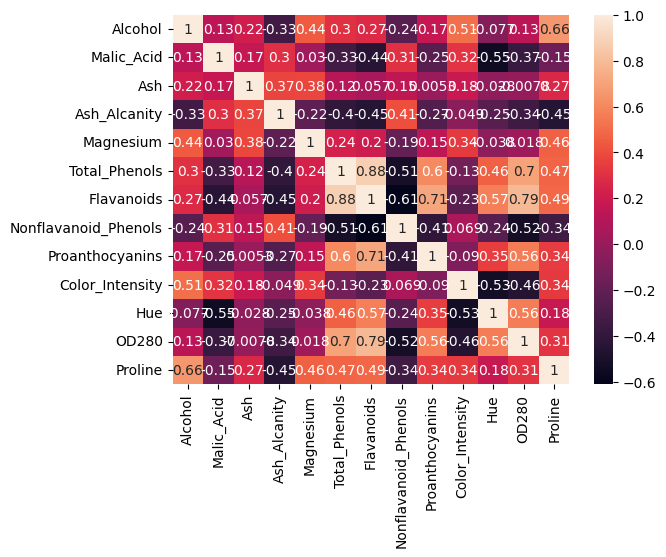

In [387]:
sns.heatmap(correlated, annot=True)

In [388]:
high_corr_columns = []
high_corr_rows = []
hig_corr = []

for i in correlated.columns:
    for j in correlated.columns:
        if i!=j:
            if correlated.loc[i, j] > 0.7:
                high_corr_columns.append(i)
                high_corr_rows.append(j)
                hig_corr.append(correlated.loc[i, j])
               

data_high_corr = {
    'Feature_1' : high_corr_columns,
    'Feature_2' : high_corr_rows,
    'Correlation' : hig_corr
}

high_corr_features = pd.DataFrame(data_high_corr)
high_corr_features
                

,Feature_1,Feature_2,Correlation
0,Total_Phenols,Flavanoids,0.876516
1,Total_Phenols,OD280,0.703578
2,Flavanoids,Total_Phenols,0.876516
3,Flavanoids,Proanthocyanins,0.714959
4,Flavanoids,OD280,0.791143
5,Proanthocyanins,Flavanoids,0.714959
6,OD280,Total_Phenols,0.703578
7,OD280,Flavanoids,0.791143


In [389]:
high_corr_features['Feature_1'].value_counts()

Feature_1
Flavanoids         3
Total_Phenols      2
OD280              2
Proanthocyanins    1
Name: count, dtype: int64

<Axes: >

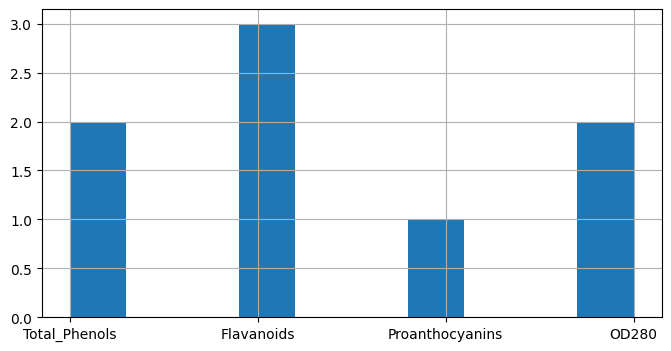

In [390]:
high_corr_features['Feature_1'].hist(figsize=(8, 4), bins=10)

In [391]:
high_corr_features['Feature_2'].value_counts()

Feature_2
Flavanoids         3
OD280              2
Total_Phenols      2
Proanthocyanins    1
Name: count, dtype: int64

<Axes: >

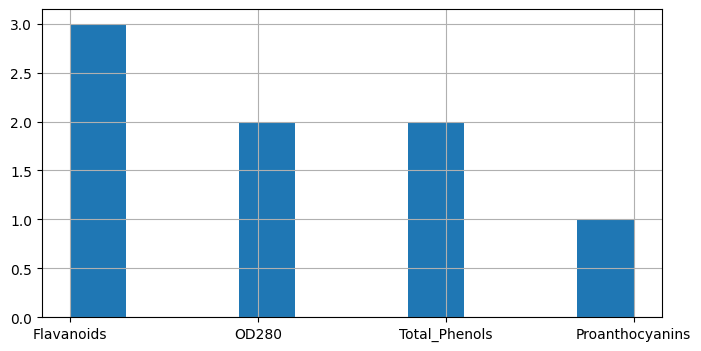

In [392]:
high_corr_features['Feature_2'].hist(figsize=(8, 4), bins=10)

In [393]:
df_exp_two.head()

,Alcohol,Malic_Acid,Ash,Ash_Alcanity,Magnesium,Total_Phenols,Flavanoids,Nonflavanoid_Phenols,Proanthocyanins,Color_Intensity,Hue,OD280,Proline
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735
5,14.20,1.76,2.45,15.2,112,3.27,3.39,0.34,1.97,6.75,1.05,2.85,1450


In [394]:
df_exp_two.drop(columns=['Total_Phenols', 
                         'OD280', 
                         'Proanthocyanins'], inplace=True)
df_exp_two.head()

,Alcohol,Malic_Acid,Ash,Ash_Alcanity,Magnesium,Flavanoids,Nonflavanoid_Phenols,Color_Intensity,Hue,Proline
0,14.23,1.71,2.43,15.6,127,3.06,0.28,5.64,1.04,1065
1,13.20,1.78,2.14,11.2,100,2.76,0.26,4.38,1.05,1050
2,13.16,2.36,2.67,18.6,101,3.24,0.30,5.68,1.03,1185
4,13.24,2.59,2.87,21.0,118,2.69,0.39,4.32,1.04,735
5,14.20,1.76,2.45,15.2,112,3.39,0.34,6.75,1.05,1450


In [395]:
preprocess = Pipeline([
    ('numeric', StandardScaler())
])
preprocess_transformed = preprocess.fit_transform(df_exp_two)
df_scaled = pd.DataFrame(preprocess_transformed, columns=df_exp_two.columns)
df_scaled.head()


,Alcohol,Malic_Acid,Ash,Ash_Alcanity,Magnesium,Flavanoids,Nonflavanoid_Phenols,Color_Intensity,Hue,Proline
0,1.611317,-0.555500,0.269218,-1.267631,2.300247,1.111273,-0.693167,0.312318,0.347579,1.071903
1,0.274905,-0.491532,-0.879972,-2.722255,0.110018,0.792590,-0.856747,-0.272245,0.392559,1.022409
2,0.223006,0.038496,1.220271,-0.275841,0.191138,1.302483,-0.529588,0.330875,0.302600,1.467858
3,0.326805,0.248679,2.012816,0.517590,1.570170,0.718231,0.206519,-0.300081,0.347579,-0.016972
4,1.572392,-0.509808,0.348472,-1.399869,1.083453,1.461824,-0.202429,0.827290,0.392559,2.342258


In [396]:
df_exp_two.isnull().sum()

Alcohol                 0
Malic_Acid              0
Ash                     0
Ash_Alcanity            0
Magnesium               0
Flavanoids              0
Nonflavanoid_Phenols    0
Color_Intensity         0
Hue                     0
Proline                 0
dtype: int64

### Task 2: Determine the Optimal Number of Clusters
- Use the **Elbow method** to determine the optimal number of clusters.
- Visualize the results using a line plot of the **Within-Cluster Sum of Squares (WCSS)** against the number of clusters.

In [397]:
kmeans = KMeans()
kmeans.fit_predict(df_scaled)

array([5, 5, 2, 2, 5, 5, 2, 5, 5, 5, 5, 5, 2, 2, 2, 5, 5, 2, 5, 0, 2, 2,
       5, 5, 2, 5, 2, 5, 2, 2, 2, 2, 2, 2, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 2, 5, 2, 5, 2, 5, 6, 6, 4, 0, 7, 0, 4, 4, 6, 6, 7,
       6, 0, 4, 4, 6, 0, 6, 4, 0, 7, 3, 0, 0, 7, 7, 6, 6, 6, 6, 6, 4, 0,
       4, 0, 4, 4, 4, 6, 4, 4, 6, 4, 6, 4, 0, 4, 7, 7, 6, 7, 4, 6, 4, 4,
       0, 3, 1, 6, 6, 7, 6, 6, 0, 1, 1, 1, 6, 1, 3, 1, 3, 3, 1, 3, 3, 1,
       1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 3, 1, 3, 3, 1, 1, 1, 3, 1, 3, 3, 1,
       1, 1, 1, 3, 1, 1])

In [398]:
kmeans.cluster_centers_

array([[-0.98066318, -0.86269116, -0.11486183, -0.32161633,  0.07257861,
         0.45593072, -0.90078741, -0.63019151,  0.32335957, -0.31698429],
       [ 0.11318258,  1.05579506, -0.17375836,  0.34638836, -0.08408912,
        -1.25646334,  0.53367761,  1.21335282, -1.44356982, -0.35577299],
       [ 0.70826575, -0.32155739,  1.24008486, -0.07748355,  0.93743792,
         0.87013648, -0.24741376,  0.0824361 ,  0.6939217 ,  1.116448  ],
       [ 0.17456607,  1.16800154,  0.99835871,  1.34408128,  0.24521767,
        -1.20236316,  0.94807862,  0.52109009, -0.69894441, -0.45472239],
       [-0.78357122, -0.42563894, -1.59326262, -0.39764013, -0.96161369,
         0.01265645, -0.36600878, -0.90002724,  0.57010962, -0.91377518],
       [ 1.07324123, -0.2214113 , -0.13987541, -1.10913901,  0.49414338,
         1.05316031, -0.8471245 ,  0.28761979,  0.25894318,  1.18593417],
       [-0.77959805, -0.36110173, -0.24773778,  0.46649792, -0.61637039,
        -0.27113377,  0.78648205, -0.86144708

In [399]:
df_scaled.shape

(160, 10)

In [400]:
wcss = []
for i in range(1, 10):
    kmeans_each = KMeans(n_clusters=i)
    kmeans_each.fit_predict(df_scaled.values)
    wcss.append(kmeans_each.inertia_)

wcss

[1599.999999999999,
 1217.3697985329063,
 860.5720892666365,
 816.2410784884049,
 739.6195769435423,
 706.1873275829668,
 685.2066076068515,
 629.3631027052761,
 631.5016140296054]

In [ ]:
labels = []
sil_score = []
cluster_range = range(2, 10)
for i in cluster_range:
    kmeans_each = KMeans(n_clusters=i, random_state=42)
    lbls = kmeans_each.fit_predict(df_scaled.values)
    score = silhouette_score(df_scaled, lbls)
    labels.append(lbls) 
    sil_score.append(score)

for l, s in zip(cluster_range, sil_score):
    print(f'Cluster {l} -> Score : {s}')

Cluster 2 -> Score : 0.24398110609287987
Cluster 3 -> Score : 0.30545926810176055
Cluster 4 -> Score : 0.26507687286337
Cluster 5 -> Score : 0.22342409581125863
Cluster 6 -> Score : 0.1462590701965652
Cluster 7 -> Score : 0.15403125738978646
Cluster 8 -> Score : 0.16698676979405289
Cluster 9 -> Score : 0.1572917565910557


In [402]:
print(f"Number of WCSS : {len(wcss)}")

Number of WCSS : 9


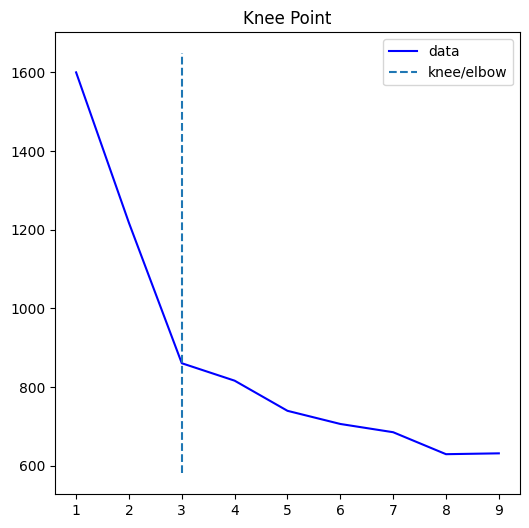

In [403]:
knee = KneeLocator(range(1, 10), wcss, curve='convex', direction='decreasing')
knee.plot_knee()

### Task 3: K-means Clustering
- Apply K-means clustering using the optimal number of clusters obtained from the Elbow method.
- Assign cluster labels to each data point and create a new column in the dataset with these labels.



In [404]:
km_optimal = KMeans(n_clusters=3)
predicted = km_optimal.fit_predict(df_scaled)
predicted

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2])

### Task 4: Cluster Analysis
- Analyze the clusters by comparing the mean values of each feature within each cluster.
- Visualize the clusters using a pairplot or scatterplot for selected features to understand the separations visually.



### Task 5: Interpretation
- Interpret the characteristics of each cluster. For example, identify which cluster has the highest alcohol content, or which has the most intense color, etc.
- Suggest potential names or categories for each cluster based on the observed characteristics.
